## Exercise 5- Regularized Linear Regression & Bias vs Variance

In [1]:
# import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.optimize
import warnings

warnings.filterwarnings('ignore')

### Regularized Linear Regression

In [2]:
input_file = 'database/ex5data1.mat'

mat_data = scipy.io.loadmat(input_file)

# training set
X, y = mat_data['X'], mat_data['y']
# cross validation set

Xval, yval = mat_data['Xval'], mat_data['yval']

# test set
Xtest, ytest = mat_data['Xtest'], mat_data['ytest']

# insert ones to all X (x0)
X = np.insert(X,0,1,axis=1)
Xval = np.insert(Xval,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

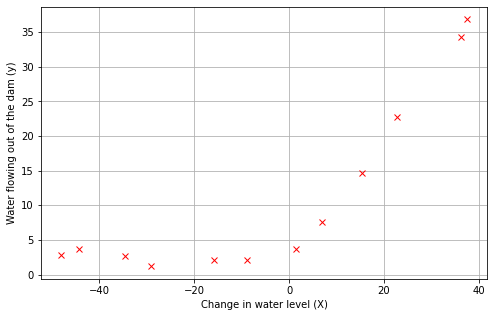

In [3]:
def plotData():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (X)')
    plt.plot(X[:,1],y,'rx')
    plt.grid(True)
    
plotData()

In [4]:
# regularized linear regression functions
# linear hypothesis function
def h(theta,X):
    return np.dot(X,theta)

# cost function
def computeCost(theta,X,y,_lambda=0.): 
    """
    theta_initial: n-dimensional vector of initial theta guess
    n: number of features
    m: number of training examples provided
    X: matrix with n-columns and m-rows
    y: m-dimensional vector
    """
    m = X.shape[0]
    _h = h(theta,X).reshape((m,1))
    cost = float((1./(2*m)) * np.dot((_h-y).T,(_h-y)))
    regularized_term = (float(_lambda)/(2*m)) * float(theta[1:].T.dot(theta[1:]))
    return cost + regularized_term

# checking
theta = np.array([[1.],[1.]])
print (computeCost(theta,X,y,_lambda=1.))

303.9931922202643


In [5]:
def computeGradient(theta,X,y,_lambda=0.):
    theta = theta.reshape((theta.shape[0],1))
    m = X.shape[0]
    
    # gradient has same shape as theta
    _h = h(theta,X).reshape((m,1))
    gradient = (1./float(m))*X.T.dot(h(theta,X)-y)
    regularized_term = (float(_lambda)/m)*theta
    regularized_term[0] = 0 # regularization for bias term not needed
    regularized_term.reshape((gradient.shape[0],1))
    return gradient + regularized_term

# returns flattened gradient, needed for minimization
def computeGradientFlattened(theta,X,y,_lambda=0.):
    return computeGradient(theta,X,y,_lambda=0.).flatten()

# checking
theta = np.array([[1.],[1.]])
print (computeGradient(theta,X,y,_lambda=1.))

[[-15.30301567]
 [598.25074417]]


Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


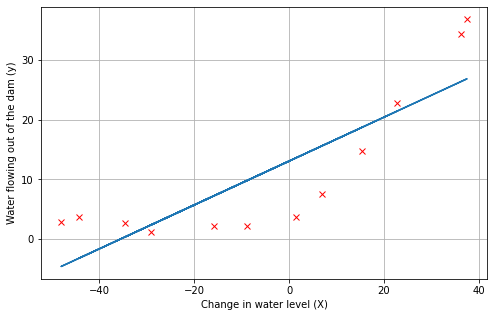

In [6]:
# optimizing
def optimizeTheta(theta_initial,X,y,_lambda=0.,print_output=True):
    fit_theta = scipy.optimize.fmin_cg(computeCost,x0=theta_initial,\
                                       fprime=computeGradientFlattened,\
                                       args=(X,y,_lambda),\
                                       disp=print_output,\
                                       epsilon=1.49e-12,\
                                       maxiter=1000)
    fit_theta = fit_theta.reshape((theta_initial.shape[0],1))
    return fit_theta

theta = np.array([[1.],[1.]])
theta_fit = optimizeTheta(theta,X,y,0.)

# plotting data
plotData()
plt.plot(X[:,1],h(theta_fit,X).flatten())

### Bias vs Variance

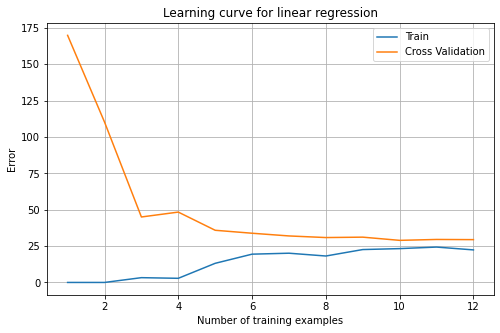

In [7]:
# learning curve for linear regression
def plotLearningCurve():
    """
    Loop over first training point, then first 2 training points, then first 3 ...
    and use each training-set subset to find trained parameters.
    With those parameters, compute the cost on that subset (Jtrain)
    remembering that for Jtrain, lambda = 0 (even if you are using regularization).
    Then, use the trained parameters to compute Jval on the entire validation set,
    again forcing lambda = 0 (even if using regularization).
    Store the computed errors, train_error and val_error and plot them.
    """
    initial_theta = np.array([[1.],[1.]])
    _m, train_error, val_error = [], [], []
    for i in range(1,13,1):
        train_subset = X[:i,:]
        y_subset = y[:i]
        _m.append(y_subset.shape[0])
        theta_fit = optimizeTheta(initial_theta,train_subset,y_subset,_lambda=0.,print_output=False)
        train_error.append(computeCost(theta_fit,train_subset,y_subset,_lambda=0.))
        val_error.append(computeCost(theta_fit,Xval,yval,_lambda=0.))
        
    plt.figure(figsize=(8,5))
    plt.plot(_m,train_error,label='Train')
    plt.plot(_m,val_error,label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)
    
plotLearningCurve()


#### The curve above suggests Underfitting, meaning that Linear Regression does not fit our data well.

In [8]:
# polynomial regression
def generatePolyFeatures(X,p):
    """
    Function takes in the X matrix (with bias term already included as the first column 
    & returns X matrix with 'p' additional columns.
    """
    X_new = X.copy()
    for i in range(p):
        dim = i+2
        X_new = np.insert(X_new,X_new.shape[1],np.power(X_new[:,1],dim),axis=1)
    return X_new

def featureNormalization(X):
    """
    Takes as input the X array (with bias "1" first column), does
    feature normalizing on the columns (subtract mean, divide by standard deviation).
    """
    
    normalized_X = X.copy()
    feature_means = np.mean(normalized_X,axis=0) #column-by-column
    normalized_X[:,1:] = normalized_X[:,1:] - feature_means[1:]
    feature_deviations = np.std(normalized_X,axis=0,ddof=1)
    normalized_X[:,1:] = normalized_X[:,1:] / feature_deviations[1:]
    return normalized_X, feature_means, feature_deviations

In [9]:
d_global = 5
X_new = generatePolyFeatures(X,d_global)
X_new_normalized, stored_means, stored_stds = featureNormalization(X_new)

theta = np.ones((X_new_normalized.shape[1],1))
theta_fit = optimizeTheta(theta,X_new_normalized,y,0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 151
         Function evaluations: 291
         Gradient evaluations: 291


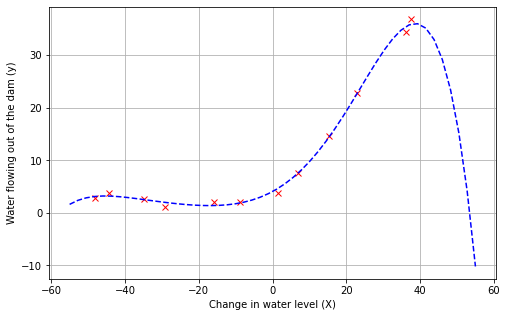

In [10]:
def fitPlot(fit_theta,means,stds):
    num_points_to_plot = 50
    x_val = np.linspace(-55,55,num_points_to_plot)
    x_mat = np.ones((num_points_to_plot,1))
    
    x_mat = np.insert(x_mat,x_mat.shape[1],x_val.T,axis=1)
    x_mat = generatePolyFeatures(x_mat,len(theta_fit)-2)
    
    # undoing feature normalization
    x_mat[:,1:] = x_mat[:,1:] - means[1:]
    x_mat[:,1:] = x_mat[:,1:] / stds[1:]
    plotData()
    plt.plot(x_val,h(theta_fit,x_mat),'b--')

fitPlot(theta_fit,stored_means,stored_stds)

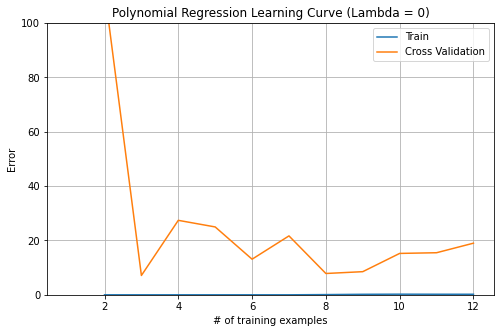

In [11]:
# learning curve for polynomial regression
def plotPolyLearningCurve(_lambda=0.):
    initial_theta = np.ones((d_global+2,1))
    _m, train_error, val_error = [], [], []
    X_val, temp1, temp2 = featureNormalization(generatePolyFeatures(Xval,d_global))

    for i in range(1,13,1):
        train_subset = X[:i,:]
        y_subset = y[:i]
        _m.append(y_subset.shape[0])
        train_subset = generatePolyFeatures(train_subset,d_global)   
        train_subset, temp1, temp2 = featureNormalization(train_subset)
        theta_fit = optimizeTheta(initial_theta,train_subset,y_subset,_lambda=_lambda,print_output=False)
        train_error.append(computeCost(theta_fit,train_subset,y_subset,_lambda=_lambda))
        val_error.append(computeCost(theta_fit,X_val,yval,_lambda=_lambda))
        
    plt.figure(figsize=(8,5))
    plt.plot(_m,train_error,label='Train')
    plt.plot(_m,val_error,label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (Lambda = 0)')
    plt.xlabel('# of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve()

         Current function value: 8.042488
         Iterations: 5
         Function evaluations: 73
         Gradient evaluations: 62


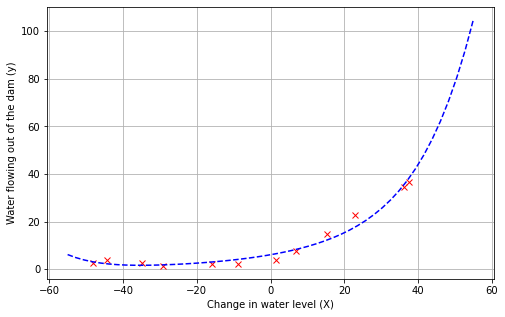

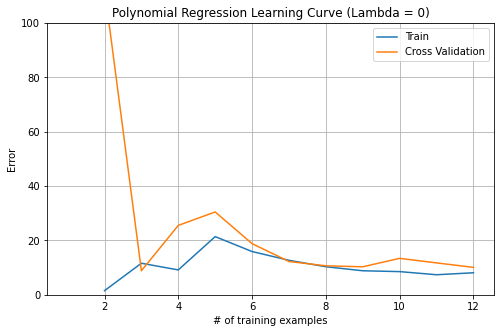

In [12]:
# regularizing, lambda = 1 
theta = np.zeros((X_new_normalized.shape[1],1))
theta_fit = optimizeTheta(theta,X_new_normalized,y,1)
fitPlot(theta_fit,stored_means,stored_stds)
plotPolyLearningCurve(1.)

         Current function value: 34.211865
         Iterations: 2
         Function evaluations: 56
         Gradient evaluations: 45


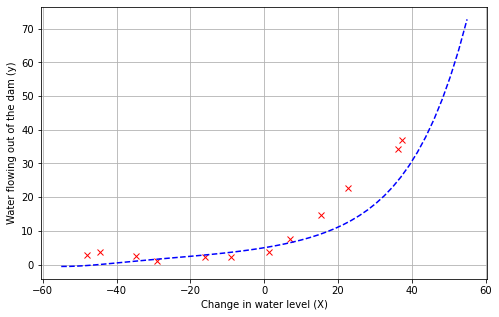

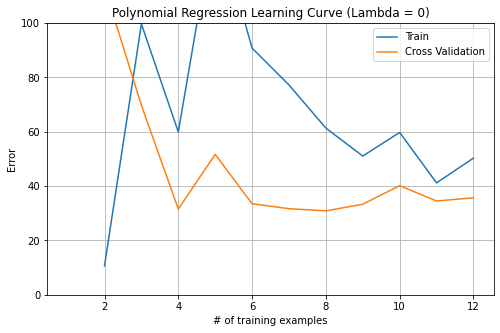

In [13]:
# regularizing, lambda = 7
theta = np.zeros((X_new_normalized.shape[1],1))
theta_fit = optimizeTheta(theta,X_new_normalized,y,7)
fitPlot(theta_fit,stored_means,stored_stds)
plotPolyLearningCurve(7.)

#### Selecting Lambda automatically

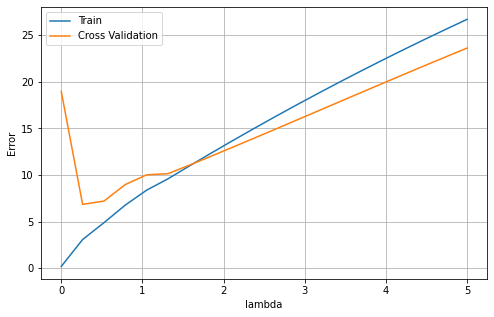

In [14]:
lambdas = np.linspace(0,5,20)
train_errors, val_errors = [], []
for _lambda in lambdas:
    X_new_train = generatePolyFeatures(X,d_global)
    X_new_train_normalized, temp1, temp2 = featureNormalization(X_new_train)
    X_new_val = generatePolyFeatures(Xval,d_global)
    X_new_val_normalized, temp1, temp2 = featureNormalization(X_new_val)
    init_theta = np.ones((X_new_normalized.shape[1],1))
    theta_fit = optimizeTheta(theta,X_new_train_normalized,y,_lambda,False)
    train_errors.append(computeCost(theta_fit,X_new_train_normalized,y,_lambda=_lambda))
    val_errors.append(computeCost(theta_fit,X_new_val_normalized,yval,_lambda=_lambda))
    
plt.figure(figsize=(8,5))
plt.plot(lambdas,train_errors,label='Train')
plt.plot(lambdas,val_errors,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)